In [ ]:
#default_exp vision.data

In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.data.all import *
from fastai2.vision.core import *

In [ ]:
#hide
from nbdev.showdoc import *
from fastai2.vision.augment import *

# Vision data

> Helper functions to get data in a `DataLoaders` un the vision application and higher class `ImageDataLoaders`

The main classes defined in this module are `ImageDataLoaders` and `SegmentationsDataLoaders`. They provide factory methods that are a great way to quickly get your data ready for training.

## Helper functions

In [ ]:
#export
@delegates(subplots)
def get_grid(n, nrows=None, ncols=None, add_vert=0, figsize=None, double=False, title=None, return_fig=False, **kwargs):
    "Return a grid of `n` axes, `rows` by `cols`"
    nrows = nrows or int(math.sqrt(n))
    ncols = ncols or int(np.ceil(n/nrows))
    if double: ncols*=2 ; n*=2
    fig,axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i<n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    if title is not None: fig.suptitle(title, weight='bold', size=14)
    return (fig,axs) if return_fig else axs

This is used by the type-dispatched versions of `show_batch` and `show_results` for the vision application. By default, there will be `int(math.sqrt(n))` rows and `ceil(n/rows)` columns. `double` will double the number of columns and `n`. The default `figsize` is `(cols*imsize, rows*imsize+add_vert)`. If a `title` is passed it is set to the figure. `sharex`, `sharey`, `squeeze`, `subplot_kw` and `gridspec_kw` are all passed down to `plt.subplots`. If `return_fig` is `True`, returns `fig,axs`, otherwise just `axs`.

In [ ]:
# export
def clip_remove_empty(bbox, label):
    "Clip bounding boxes with image border and label background the empty ones"
    bbox = torch.clamp(bbox, -1, 1)
    empty = ((bbox[...,2] - bbox[...,0])*(bbox[...,3] - bbox[...,1]) < 0.)
    return (bbox[~empty], label[~empty])

In [ ]:
bb = tensor([[-2,-0.5,0.5,1.5], [-0.5,-0.5,0.5,0.5], [1,0.5,0.5,0.75], [-0.5,-0.5,0.5,0.5]])
bb,lbl = clip_remove_empty(bb, tensor([1,2,3,2]))
test_eq(bb, tensor([[-1,-0.5,0.5,1.], [-0.5,-0.5,0.5,0.5], [-0.5,-0.5,0.5,0.5]]))
test_eq(lbl, tensor([1,2,2]))

In [ ]:
#export
def bb_pad(samples, pad_idx=0):
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    samples = [(s[0], *clip_remove_empty(*s[1:])) for s in samples]
    max_len = max([len(s[2]) for s in samples])
    def _f(img,bbox,lbl):
        bbox = torch.cat([bbox,bbox.new_zeros(max_len-bbox.shape[0], 4)])
        lbl  = torch.cat([lbl, lbl .new_zeros(max_len-lbl .shape[0])+pad_idx])
        return img,bbox,lbl
    return [_f(*s) for s in samples]

In [ ]:
img1,img2 = TensorImage(torch.randn(16,16,3)),TensorImage(torch.randn(16,16,3))
bb1 = tensor([[-2,-0.5,0.5,1.5], [-0.5,-0.5,0.5,0.5], [1,0.5,0.5,0.75], [-0.5,-0.5,0.5,0.5]])
lbl1 = tensor([1, 2, 3, 2])
bb2 = tensor([[-0.5,-0.5,0.5,0.5], [-0.5,-0.5,0.5,0.5]])
lbl2 = tensor([2, 2])
samples = [(img1, bb1, lbl1), (img2, bb2, lbl2)]
res = bb_pad(samples)
non_empty = tensor([True,True,False,True])
test_eq(res[0][0], img1)
test_eq(res[0][1], tensor([[-1,-0.5,0.5,1.], [-0.5,-0.5,0.5,0.5], [-0.5,-0.5,0.5,0.5]]))
test_eq(res[0][2], tensor([1,2,2]))
test_eq(res[1][0], img2)
test_eq(res[1][1], tensor([[-0.5,-0.5,0.5,0.5], [-0.5,-0.5,0.5,0.5], [0,0,0,0]]))
test_eq(res[1][2], tensor([2,2,0]))      

## Show methods -

In [ ]:
#export
@typedispatch
def show_batch(x:TensorImage, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [ ]:
#export
@typedispatch
def show_batch(x:TensorImage, y:TensorImage, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize, double=True)
    for i in range(2):
        ctxs[i::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs[i::2],range(max_n))]
    return ctxs

## `TransformBlock`s for vision

These are the blocks the vision application provide for the [data block API](http://dev.fast.ai/data.block).

In [ ]:
#export
def ImageBlock(cls=PILImage): 
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

In [ ]:
#export
def MaskBlock(codes=None):
    "A `TransformBlock` for segmentation masks, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), batch_tfms=IntToFloatTensor)

In [ ]:
#export
PointBlock = TransformBlock(type_tfms=TensorPoint.create, item_tfms=PointScaler)
BBoxBlock = TransformBlock(type_tfms=TensorBBox.create, item_tfms=PointScaler, dls_kwargs = {'before_batch': bb_pad})

PointBlock.__doc__ = "A `TransformBlock` for points in an image"
BBoxBlock.__doc__  = "A `TransformBlock` for bounding boxes in an image"

In [ ]:
show_doc(PointBlock, name='PointBlock')

<h4 id="PointBlock" class="doc_header"><code>PointBlock</code><a href="" class="source_link" style="float:right">[source]</a></h4>

A [`TransformBlock`](/data.block#TransformBlock) for points in an image

In [ ]:
show_doc(BBoxBlock, name='BBoxBlock')

<h4 id="BBoxBlock" class="doc_header"><code>BBoxBlock</code><a href="" class="source_link" style="float:right">[source]</a></h4>

A [`TransformBlock`](/data.block#TransformBlock) for bounding boxes in an image

In [ ]:
#export
def BBoxLblBlock(vocab=None, add_na=True):
    "A `TransformBlock` for labeled bounding boxes, potentially with `vocab`"
    return TransformBlock(type_tfms=MultiCategorize(vocab=vocab, add_na=add_na), item_tfms=BBoxLabeler)

If `add_na` is `True`, a new category is added for NaN (that will represent the background class).

## ImageDataLoaders -

In [ ]:
#export
class ImageDataLoaders(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for computer vision problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None, 
                    batch_tfms=None, **kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        dblock = DataBlock(blocks=(ImageBlock, CategoryBlock(vocab=vocab)),
                           get_items=get_image_files,
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`"
        dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, fnames, path=path, **kwargs)

    @classmethod
    def from_name_func(cls, path, fnames, label_func, **kwargs):
        "Create from name attrs in list of `fnames` in `path`s with `label_func`"
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, **kwargs):
        "Create from list of `fnames` in `path`s with re expression `pat`."
        return cls.from_path_func(path, fnames, RegexLabeller(pat), **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, **kwargs):
        "Create from name attrs in list of `fnames` in `path`s with re expression `pat`."
        return cls.from_name_func(path, fnames, RegexLabeller(pat), **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(ImageBlock, y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_lists(cls, path, fnames, labels, valid_pct=0.2, seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   **kwargs):
        "Create from list of `fnames` in `path`."
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        dblock = DataBlock(blocks=(ImageBlock, y_block),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, (fnames, labels), path=path, **kwargs)

ImageDataLoaders.from_csv = delegates(to=ImageDataLoaders.from_df)(ImageDataLoaders.from_csv)
ImageDataLoaders.from_name_func = delegates(to=ImageDataLoaders.from_path_func)(ImageDataLoaders.from_name_func)
ImageDataLoaders.from_path_re = delegates(to=ImageDataLoaders.from_path_func)(ImageDataLoaders.from_path_re)
ImageDataLoaders.from_name_re = delegates(to=ImageDataLoaders.from_name_func)(ImageDataLoaders.from_name_re)

This class should not be used directly, one of the factory methods should be prefered instead. All those factory methods accept as arguments:

- `item_tfms`: one or several transforms applied to the items before batching them
- `batch_tfms`: one or several transforms applied to the batches once they are formed
- `bs`: the batch size
- `val_bs`: the batch size for the validation `DataLoader` (defaults to `bs`)
- `shuffle_train`: if we shuffle the training `DataLoader` or not
- `device`: the PyTorch device to use (defaults to `default_device()`)

In [ ]:
show_doc(ImageDataLoaders.from_folder)

<h4 id="ImageDataLoaders.from_folder" class="doc_header"><code>ImageDataLoaders.from_folder</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageDataLoaders.from_folder</code>(**`path`**, **`train`**=*`'train'`*, **`valid`**=*`'valid'`*, **`valid_pct`**=*`None`*, **`seed`**=*`None`*, **`vocab`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)

If `valid_pct` is provided, a random split is performed (with an optional `seed`) by setting aside that percentage of the data for the validation set. If a `vocab` is passed, only the folders with names in `vocab` are kept.

In [ ]:
show_doc(ImageDataLoaders.from_path_func)

<h4 id="ImageDataLoaders.from_path_func" class="doc_header"><code>ImageDataLoaders.from_path_func</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageDataLoaders.from_path_func</code>(**`path`**, **`fnames`**, **`label_func`**, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from list of `fnames` in `path`s with `label_func`

In [ ]:
show_doc(ImageDataLoaders.from_path_re)

<h4 id="ImageDataLoaders.from_path_re" class="doc_header"><code>ImageDataLoaders.from_path_re</code><a href="__main__.py#L35" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageDataLoaders.from_path_re</code>(**`path`**, **`fnames`**, **`pat`**, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from list of `fnames` in `path`s with re expression `pat`.

In [ ]:
show_doc(ImageDataLoaders.from_name_func)

<h4 id="ImageDataLoaders.from_name_func" class="doc_header"><code>ImageDataLoaders.from_name_func</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageDataLoaders.from_name_func</code>(**`path`**, **`fnames`**, **`label_func`**, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from name attrs in list of `fnames` in `path`s with `label_func`

In [ ]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/"images")

In [ ]:
def label_func(x):
    return re.search(r'^(.*)_\d+.jpg', x).groups()[0]

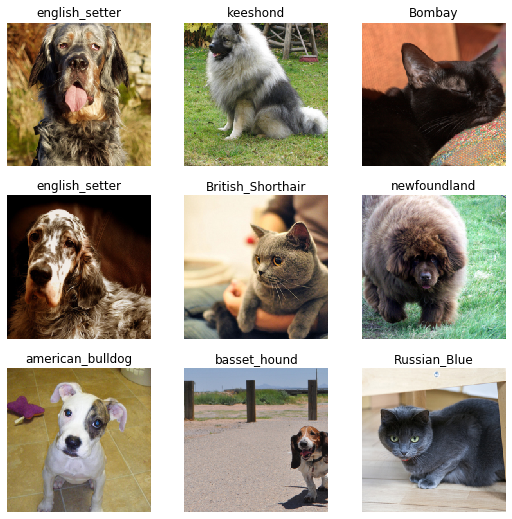

In [ ]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/"images")
dls = ImageDataLoaders.from_name_func(path, fnames, label_func, item_tfms=Resize(224))
dls.show_batch()

In [ ]:
show_doc(ImageDataLoaders.from_name_re)

<h4 id="ImageDataLoaders.from_name_re" class="doc_header"><code>ImageDataLoaders.from_name_re</code><a href="__main__.py#L40" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageDataLoaders.from_name_re</code>(**`path`**, **`fnames`**, **`pat`**, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from name attrs in list of `fnames` in `path`s with re expression `pat`.

In [ ]:
show_doc(ImageDataLoaders.from_df)

<h4 id="ImageDataLoaders.from_df" class="doc_header"><code>ImageDataLoaders.from_df</code><a href="__main__.py#L46" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageDataLoaders.from_df</code>(**`df`**, **`path`**=*`'.'`*, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`fn_col`**=*`0`*, **`folder`**=*`None`*, **`suff`**=*`''`*, **`label_col`**=*`1`*, **`label_delim`**=*`None`*, **`y_block`**=*`None`*, **`valid_col`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)



In [ ]:
show_doc(ImageDataLoaders.from_csv)

<h4 id="ImageDataLoaders.from_csv" class="doc_header"><code>ImageDataLoaders.from_csv</code><a href="__main__.py#L63" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageDataLoaders.from_csv</code>(**`path`**, **`csv_fname`**=*`'labels.csv'`*, **`header`**=*`'infer'`*, **`delimiter`**=*`None`*, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`fn_col`**=*`0`*, **`folder`**=*`None`*, **`suff`**=*`''`*, **`label_col`**=*`1`*, **`label_delim`**=*`None`*, **`y_block`**=*`None`*, **`valid_col`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)



In [ ]:
show_doc(ImageDataLoaders.from_lists)

<h4 id="ImageDataLoaders.from_lists" class="doc_header"><code>ImageDataLoaders.from_lists</code><a href="__main__.py#L68" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageDataLoaders.from_lists</code>(**`path`**, **`fnames`**, **`labels`**, **`valid_pct`**=*`0.2`*, **`seed`**:`int`=*`None`*, **`y_block`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from list of `fnames` in `path`.

In [ ]:
#export
class SegmentationDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [ ]:
show_doc(SegmentationDataLoaders.from_label_func)

<h4 id="SegmentationDataLoaders.from_label_func" class="doc_header"><code>SegmentationDataLoaders.from_label_func</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>SegmentationDataLoaders.from_label_func</code>(**`path`**, **`fnames`**, **`label_func`**, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`codes`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from list of `fnames` in `path`s with `label_func`.

# Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 19_callback.mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 20a_distributed.ipynb.
Converted 21_vision.learner.ipynb.
Converted 22_tutorial.ima